In [22]:
!pip install geopandas
!pip install descartes

In [23]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import geopandas as gpd
import matplotlib.pyplot as plt

In [28]:
#alle dataframes
df_life = pd.read_csv("./life_expectancy.csv")
df_accidents = pd.read_csv("./accidents_2017.csv")
df_accidents.rename(columns = {'Neighborhood Name':'Neighborhood', 'District Name': 'District'}, inplace = True) 
map_df = gpd.read_file('districtes.geojson').filter(items=['NOM', 'geometry'])
df_deaths = pd.read_csv("./deaths.csv")
df_transport= pd.read_csv("./transports.csv")
unemployment_df = pd.read_csv('unemployment.csv')
population_df = pd.read_csv('population.csv')
air_quality_df = pd.read_csv('datasets_71509_948751_air_quality_Nov2017.csv')

# Data story 1
## De leefbaarheid van de districten in Barcelona is slechter naarmate ze dichter bij de Mediterraanse zee liggen.
### Inleiding

In [25]:
unemployment_df = unemployment_df[(unemployment_df['Year'] == 2017) & (unemployment_df["Demand_occupation"] == "Registered unemployed") & (unemployment_df['Month'] == "December")]
unemployment_df = unemployment_df.groupby('District Name').sum().head(50)
unemployment_df = unemployment_df.filter(items=["Number"]).rename(columns={"Number": "unemployment"})

population = population_df.filter(['Year', 'Number', 'District.Name'])
population = population[population['Year'] == 2017].groupby('District.Name').sum().drop('Year', axis=1).rename(columns={"Number": "population"})
population = population.join(unemployment_df)
population['percentage'] = population['unemployment'] / population['population'] * 100

map_df = map_df.set_index('NOM').join(population)

Text(0.5, 1, 'Unemployment rate in Barcelona per district in 2017 as percentage of the population')

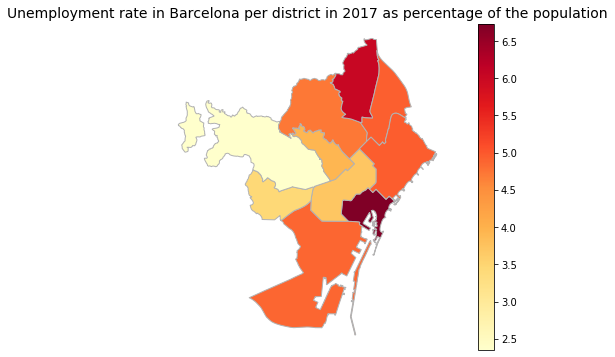

In [26]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'percentage'

# set the range for the choropleth
vmin, vmax = 0, 10

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# create map
ax.axis('off')
map_df.plot(column='percentage', ax=ax, legend=True, cmap='YlOrRd', edgecolor='.7')
ax.set_title('Unemployment rate in Barcelona per district in 2017 as percentage of the population', fontdict={'fontsize': '14', 'fontweight' : '3'})


#### Tekst voor onder bovenstaande map

In [29]:
order = ['Barcelona - Ciutadella', 'Barcelona - Poblenou', 'Barcelona - Eixample', 'Barcelona - Gràcia', 'Barcelona - Palau Reial', 'Barcelona - Vall Hebron', 'Barcelona - Observ Fabra']
air_quality_df = air_quality_df.filter(['Station', 'O3 Value', 'NO2 Value', 'PM10 Value']).fillna(method='ffill')
air_quality_df = air_quality_df.groupby('Station').mean().reindex(order)

In [30]:
# Create figure
fig = go.Figure()

fig.add_trace(go.Bar(x=list(air_quality_df.index), y=list(air_quality_df['PM10 Value']),
                        name = 'PM10 air value'))

fig.add_trace(go.Bar(x=list(air_quality_df.index), y=list(air_quality_df['NO2 Value']),
                        name = 'NO2 air value'))

fig.add_trace(go.Bar(x=list(air_quality_df.index), y=list(air_quality_df['O3 Value']),
                        name = 'O3 air value'))

updatemenus = list([
    dict(active=-1,
        buttons=list([
            dict(label= 'PM10 air value',
                method = 'update',
                args = [{'visible': [False, True, False]},
                       {'title' : 'PM10 air value'}]), 
            dict(label = 'NO2 air value',
                method = 'update',
                args = [{'visible' : [True, False, False]},
                       {'title' : 'NO2 air value'}]),
            dict(label = 'O3 air value',
                method = 'update',
                args = [{'visible' : [False, False, True]},
                       {'title' : 'O3 air value'}]),
        ]),
    )
])

fig.update_layout(dict(yaxis_title = 'Value',
                xaxis_title =  'Meetstations van Barcelona, van dichtbij tot ver van de zee',
                showlegend = False,
                title = 'Values of NO2, PM10 and O3',
                updatemenus=updatemenus))

fig.show()

### tekst voor bovenstaande grafiek

In [ ]:
#index die wordt gebruikt op basis van districen van dichtbij tot veraf van de zee
index_zee = ['Ciutat Vella', 'Sant Martí', 'Sants-Montjuïc', 'Eixample', 'Sant Andreu', 'Les Corts', 'Gràcia', 'Horta-Guinardó', 'Sarrià-Sant Gervasi', 'Nou Barris'  ]

dis_neigh = []
for row in df_accidents.itertuples():
    district = [row.Neighborhood, row.District]
    dis_neigh.append(district)

unique_dis_neigh = [list(x) for x in set(tuple(x) for x in dis_neigh)]

# nieuwe kolomn toevoegen aan life_expectencay
df_life['district'] = [0 for i in range(len(df_life))]
df_life_male = df_life.copy()
df_life_male = df_life_male[df_life_male['Gender'] == 'Male']

for i, row in df_life_male.iterrows():
    for iets in unique_dis_neigh:
        if iets[0] == row['Neighborhood']:
            df_life_male.loc[i, 'district'] = iets[1]


#onderstaande regel steeds aanpassen 2x
df_life_update = df_life_male[df_life_male['district'] != 0]

mean_life = df_life_update.groupby('district').mean()
mean_life = mean_life.reindex(index_zee)

In [ ]:
#creeer figuur op basis van life expentecy
fig = go.Figure()

for step in mean_life.columns:
    fig.add_trace(
    go.Scatter(
            visible=False,
            x= mean_life.index,
            y= mean_life[step]))
    
fig.data[0].visible = True

steps = []
for i in range(len(fig.data)):
    step=dict(
        method= 'update',
        label = mean_life.columns[i],
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Life expentancy of people in districts of Barcelona in " + mean_life.columns[i]}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    yaxis_title = 'Life expectancy',
    yaxis = dict(range=[75, 95]),
    xaxis_tickangle=20,
    xaxis_title = 'Districten van Barcelona, van dichtbij tot ver van de zee'
)

#assen range moet nog hetzelfde blijven
fig.show()

### tekst voor bovenstaande grafiek + afsluiting

# Data story 2
## De leefbaarheid van de districten in Barcelona is beter naarmate ze dichter bij de Mediterraanse zee liggen.
### tekst voor inleiding

In [16]:
#data voor de bubble chart maken

df_deaths_2017 = df_deaths[df_deaths['Year'] == 2017]
deaths_district = df_deaths_2017.groupby('District.Name').sum()

deaths_district = deaths_district['Number']
deaths_district = deaths_district.reindex(index_zee)

df_population = pd.read_csv("./population.csv")
df_population_2017 = df_population[df_population['Year'] == 2017]
population_district = df_population_2017.groupby('District.Name').sum()

population_district = population_district['Number']
population_district = population_district.reindex(index_zee)

deaths = deaths_district.values
population = population_district.values

#doden naar verhouding van populatie
deaths_of_population = []
for i in range(len(deaths)):
    value = (deaths[i]/population[i])*100
    deaths_of_population.append(value)  

accidents_2017 = df_accidents.groupby('District').sum()
accidents_2017 = accidents_2017['Victims']
accidents_2017 = accidents_2017.reindex(index_zee)

accidents = accidents_2017.values

#accidents naar verhouding van populatie
accidents_of_population = []
for i in range(len(accidents_2017)):
    value = (accidents[i]/population[i])*100
    accidents_of_population.append(value)

In [33]:
#bubble chart maken
fig2 = go.Figure(data=[go.Scatter(
    x= deaths_district.index, 
    y= deaths_of_population,
    mode = 'lines + markers',
)])

fig2.update_layout(
    yaxis_title = 'Number of deaths in relation to the population', 
    xaxis_title = 'Districten van Barcelona, van dichtbij tot ver van de zee'
)

# plus nog tekst over de hovers ook over de grootte
fig2.show()

### Tekst voor bovenstaande grafiek

In [9]:

df_transport = df_transport.groupby(['District.Name', 'Transport']).size()
soorten_transport = [4, 4, 7, 5, 3, 2, 2,1, 4, 2]

fig4 = go.Figure([go.Bar(x=districten, y= soorten_transport)])
fig4.show()

### Tekst voor bovenstaande grafiek

In [ ]:
df_accidents = df_accidents[df_accidents["Neighborhood"] != "Unknown"]

df_accidents_count_serious = df_accidents.groupby(['District', 'Serious injuries']).count()
df_accidents_count_mild = df_accidents.groupby(['District', 'Mild injuries']).count()
df_accidents_count = df_accidents.groupby('District').count()
df_accidents_count = df_accidents_count.reindex(index_zee)

df_accidents_victims = df_accidents.groupby(['District', 'Victims']).count()
victims_district_orgineel = [634, 1645, 1316, 3562, 704, 894, 588, 839, 1290, 661]

# victims van district van dichtbij naar ver van de zee
victims_district = [634, 1645, 1316, 3562, 704, 894, 588, 839, 1290, 661]
# victims naar verhouding van alle accidents in een district
for i in range(len(victims_district)):
    victims_district[i] = (victims_district[i]/population[i])*5000
        
# serieus injuries per district van dichtbij naar ver van de zee
serious_injuries = [11, 51, 21, 60, 11, 27, 12, 10,  24, 13 ]
# serieus injuries naar verhouden van alle victims in een district
for i in range(len(serious_injuries)):
    serious_injuries[i] = (serious_injuries[i]/victims_district_orgineel[i])*100
    
# mild injuries per district van dichtbij naar ver van de zee
mild_injuries = [603, 1593, 1305, 3508, 693, 865, 576, 827, 1266, 647]
# mild injuries naar verhouden van alle victims in een district
for i in range(len(mild_injuries)):
    mild_injuries[i] = (mild_injuries[i]/victims_district_orgineel[i])*100
    

In [34]:
fig6= go.Figure()

fig6.add_trace(go.Scatter(y = serious_injuries, x= index_zee, 
                            mode = 'markers',
                            marker=dict(size=victims_district),
                            marker_color = 'lime',
                            name = 'Size = aantal victims in verhouding tot populatie',
                            ))

fig6.add_trace(go.Scatter(y = mild_injuries, x= index_zee, 
                        mode = 'markers',
                        marker=dict(size=victims_district),
                        marker_color = 'cyan',
                        name = 'Size = totale victims in verhouding tot populatie'))


updatemenus = list([
    dict(active=-1,
        buttons=list([
            dict(label= 'Mild injuries',
                method = 'update',
                args = [{'visible': [False, True]},
                       {'title' : 'Mild injuries'}]), 
            dict(label = 'Serious injuries',
                method = 'update',
                args = [{'visible' : [True, False]},
                       {'title' : 'Serious injuries'}]),
        ]),
    )
])

fig6.update_layout(dict(yaxis_title = 'Percentage serieus injuries van het totale aantal victims',
                xaxis_title =  'Districten van Barcelona, van dichtbij tot ver van de zee',
                showlegend = True,
                title = 'Injuries en victims per district in Barcelona in 2017',
                updatemenus=updatemenus))


fig6.show()

### tekst voor bovenstaande grafiek + afsluiting